In [2]:
!nvidia-smi

Tue Jun 25 09:18:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.76                 Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1650 Ti   WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   51C    P0             15W /   50W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
# # Install libraries and restart kernel.
#!pip install -qqqU wandb transformers lightning albumentations torchmetrics torchinfo
#!pip install -qqq requests gradio

In [4]:
import os
import zipfile
import platform
import warnings
from glob import glob
from dataclasses import dataclass

# To filter UserWarning.
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
from albumentations.pytorch import ToTensorV2

In [6]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


# For data augmentation and preprocessing.
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Imports required SegFormer classes
from transformers import SegformerForSemanticSegmentation

# Importing lighting along with a built-in callback it provides.
import lightning.pytorch as pl
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint

# Importing torchmetrics modular and functional implementations.
from torchmetrics import MeanMetric
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix
from torchmetrics.classification import BinaryPrecisionRecallCurve
from torchmetrics.detection import IntersectionOverUnion

# To print model summary.
from torchinfo import summary

c:\Users\minik\anaconda3\envs\PyTorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Sets the internal precision of float32 matrix multiplications.
torch.set_float32_matmul_precision('high')

# To enable determinism.
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"

# To render the matplotlib figure in the notebook.
%matplotlib inline

In [8]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: anony-mouse-576901832810603240. Use `wandb login --relogin` to force relogin


True

In [46]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES:   int = 2 # including background.
    IMAGE_SIZE: tuple[int,int] = (512, 512) # W, H
    MEAN: tuple = (0.485, 0.456, 0.406)
    STD:  tuple = (0.229, 0.224, 0.225)
    BACKGROUND_CLS_ID: int = 0
    #URL: str = r"https://www.dropbox.com/scl/fi/r0685arupp33sy31qhros/dataset_UWM_GI_Tract_train_valid.zip?rlkey=w4ga9ysfiuz8vqbbywk0rdnjw&dl=1"
    DATASET_PATH: str = "C:\\Users\\minik\\Desktop\\datasets\\only_tubulitis\\only_tubulitis\\"
    DATASET_PATH_TEST: str ="C:\\Users\\minik\\Desktop\\datasets\\only_tubulitis\\only_tubulitis\\"

@dataclass(frozen=True)
class Paths:
    DATA_TRAIN_IMAGES: str = os.path.join(DatasetConfig.DATASET_PATH, "train", "images", r"*.png")
    DATA_TRAIN_LABELS: str = os.path.join(DatasetConfig.DATASET_PATH, "train", "masks",  r"*.png")
    DATA_VALID_IMAGES: str = os.path.join(DatasetConfig.DATASET_PATH, "val", "images", r"*.png")
    DATA_VALID_LABELS: str = os.path.join(DatasetConfig.DATASET_PATH, "val", "masks",  r"*.png")
    DATA_TEST_IMAGES: str = os.path.join(DatasetConfig.DATASET_PATH_TEST, "test", "images", r"*.png")
    DATA_TEST_LABELS: str = os.path.join(DatasetConfig.DATASET_PATH_TEST, "test", "masks",  r"*.png")
        
@dataclass
class TrainingConfig:
    BATCH_SIZE:      int = 1 # 8
    NUM_EPOCHS:      int = 1
    INIT_LR:       float = 3e-4
    NUM_WORKERS:     int = 0 if platform.system() == "Windows" else os.cpu_count()

    OPTIMIZER_NAME:  str = "AdamW"
    WEIGHT_DECAY:  float = 1e-4
    USE_SCHEDULER:  bool = True # Use learning rate scheduler?
    SCHEDULER:       str = "MultiStepLR" # Name of the scheduler to use.
    MODEL_NAME:str = "nvidia/segformer-b4-finetuned-ade-512-512" 
    

@dataclass
class InferenceConfig:
    BATCH_SIZE:  int = 2
    NUM_BATCHES: int = 2

In [10]:
# Create a mapping of class ID to RGB value.
id2color = {
    0: (0, 0, 0),    # background pixel
    1: (255, 0, 10),  # Tubulitis
}


DatasetConfig.NUM_CLASSES = len(id2color)

print("Number of classes", DatasetConfig.NUM_CLASSES)

# Reverse id2color mapping.
# Used for converting RGB mask to a single channel (grayscale) representation.
rev_id2color = {value: key for key, value in id2color.items()}

Number of classes 2


In [11]:
# Custom Class for creating training and validation (segmentation) dataset objects.

class MedicalDataset(Dataset):
    def __init__(self, *, image_paths, mask_paths, img_size, ds_mean, ds_std, is_train=False):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths  
        self.is_train    = is_train
        self.img_size    = img_size
        self.ds_mean = ds_mean
        self.ds_std = ds_std
        self.transforms  = self.setup_transforms(mean=self.ds_mean, std=self.ds_std)

    def __len__(self):
        return len(self.image_paths)

    def setup_transforms(self, *, mean, std):
        transforms = []

        # Augmentation to be applied to the training set.
        if self.is_train:
            transforms.extend([
                A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5),
                A.ShiftScaleRotate(scale_limit=0.12, rotate_limit=0.15, shift_limit=0.12, p=0.5),
                A.RandomBrightnessContrast(p=0.5),
                A.CoarseDropout(max_holes=8, max_height=self.img_size[1]//20, max_width=self.img_size[0]//20, min_holes=5, fill_value=0, mask_fill_value=0, p=0.5)
            ])

        # Preprocess transforms - Normalization and converting to PyTorch tensor format (HWC --> CHW).
        transforms.extend([
                A.Normalize(mean=mean, std=std, always_apply=True),
                ToTensorV2(always_apply=True),  # (H, W, C) --> (C, H, W)
        ])
        return A.Compose(transforms)

    def load_file(self, file_path, depth=0):
        file = cv2.imread(file_path, depth)
        if depth == cv2.IMREAD_COLOR:
            file = file[:, :, ::-1]
        return cv2.resize(file, (self.img_size), interpolation=cv2.INTER_NEAREST)

    def __getitem__(self, index):
        # Load image and mask file.
        image = self.load_file(self.image_paths[index], depth=cv2.IMREAD_COLOR)
        mask  = self.load_file(self.mask_paths[index],  depth=cv2.IMREAD_GRAYSCALE)
        mask = np.where(mask<254, 0, 1)
        
        # Apply Preprocessing (+ Augmentations) transformations to image-mask pair
        transformed = self.transforms(image=image, mask=mask)
        image, mask = transformed["image"], transformed["mask"].to(torch.long)
        return image, mask

In [12]:
class MedicalSegmentationDataModule(pl.LightningDataModule):
    def __init__(
        self,
        num_classes=2,
        img_size=(384, 384),
        ds_mean=(0.485, 0.456, 0.406),
        ds_std=(0.229, 0.224, 0.225),
        batch_size=1,
        num_workers=0,
        pin_memory=False,
        shuffle_validation=False,
    ):
        super().__init__()

        self.num_classes = num_classes
        self.img_size    = img_size
        self.ds_mean     = ds_mean
        self.ds_std      = ds_std
        self.batch_size  = batch_size
        self.num_workers = num_workers
        self.pin_memory  = pin_memory
        
        self.shuffle_validation = shuffle_validation


    def setup(self, *args, **kwargs):
        # Create training dataset and dataloader.
        train_imgs = sorted(glob(f"{Paths.DATA_TRAIN_IMAGES}"))
        train_msks  = sorted(glob(f"{Paths.DATA_TRAIN_LABELS}"))

        # Create validation dataset and dataloader.
        valid_imgs = sorted(glob(f"{Paths.DATA_VALID_IMAGES}"))
        valid_msks = sorted(glob(f"{Paths.DATA_VALID_LABELS}"))


        test_imgs = sorted(glob(f"{Paths.DATA_TEST_IMAGES}"))
        test_msks = sorted(glob(f"{Paths.DATA_TEST_LABELS}"))

        self.train_ds = MedicalDataset(image_paths=train_imgs, mask_paths=train_msks, img_size=self.img_size,  
                                       is_train=True, ds_mean=self.ds_mean, ds_std=self.ds_std)

        self.valid_ds = MedicalDataset(image_paths=valid_imgs, mask_paths=valid_msks, img_size=self.img_size, 
                                       is_train=False, ds_mean=self.ds_mean, ds_std=self.ds_std)
        
        self.test_ds = MedicalDataset(image_paths=test_imgs, mask_paths=test_msks, img_size=self.img_size, 
                                       is_train=False, ds_mean=self.ds_mean, ds_std=self.ds_std)

    def train_dataloader(self):
        # Create train dataloader object with drop_last flag set to True.
        return DataLoader(
            self.train_ds, batch_size=self.batch_size,  pin_memory=self.pin_memory, 
            num_workers=self.num_workers, drop_last=True, shuffle=True
        )    

    def val_dataloader(self):
        # Create validation dataloader object.
        return DataLoader(
            self.valid_ds, batch_size=self.batch_size,  pin_memory=self.pin_memory, 
            num_workers=self.num_workers, shuffle=self.shuffle_validation
        )
    def test_dataloader(self):
        # Create validation dataloader object.
        return DataLoader(
            self.test_ds, batch_size=self.batch_size,  pin_memory=self.pin_memory, 
            num_workers=self.num_workers, shuffle=self.shuffle_validation
        )

In [13]:
%%time

dm = MedicalSegmentationDataModule(
    num_classes=DatasetConfig.NUM_CLASSES,
    img_size=DatasetConfig.IMAGE_SIZE,
    ds_mean=DatasetConfig.MEAN,
    ds_std=DatasetConfig.STD,
    batch_size=InferenceConfig.BATCH_SIZE,
    num_workers=0,
    shuffle_validation=True,
)

# Donwload dataset.
dm.prepare_data()

# Create training & validation dataset.
dm.setup()

train_loader, valid_loader = dm.train_dataloader(), dm.val_dataloader()

test_loader = dm.test_dataloader()

CPU times: total: 0 ns
Wall time: 19 ms


In [14]:
def num_to_rgb(num_arr, color_map=id2color):
    single_layer = np.squeeze(num_arr)
    output = np.zeros(num_arr.shape[:2] + (3,))
 
    for k in color_map.keys():
        output[single_layer == k] = color_map[k]
 
    # return a floating point array in range [0.0, 1.0]
    return np.float32(output) / 255.0

In [15]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):
    alpha = 0.5  # Transparency for the original image.
    beta = 0.5  # Transparency for the segmentation map.
    gamma = 0.0  # Scalar added to each sum.

    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    return np.clip(image, 0.0, 1.0)

In [16]:
def display_image_and_mask(*, images, masks, color_map=id2color):
    title = ["GT Image", "Color Mask", "Overlayed Mask"]

    for idx in range(images.shape[0]):
        image = images[idx]
        grayscale_gt_mask = masks[idx]

        fig = plt.figure(figsize=(15, 4))

        # Create RGB segmentation map from grayscale segmentation map.
        rgb_gt_mask = num_to_rgb(grayscale_gt_mask, color_map=color_map)

        # Create the overlayed image.
        overlayed_image = image_overlay(image, rgb_gt_mask)

        plt.subplot(1, 3, 1)
        plt.title(title[0])
        plt.imshow(image)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.title(title[1])
        plt.imshow(rgb_gt_mask)
        plt.axis("off")

        plt.imshow(rgb_gt_mask)
        plt.subplot(1, 3, 3)
        plt.title(title[2])
        plt.imshow(overlayed_image)
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    return

In [17]:
def denormalize(tensors, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    for c in range(3):
        tensors[:, c, :, :].mul_(std[c]).add_(mean[c])

    return torch.clamp(tensors, min=0.0, max=1.0)

[0 1]
batch_images shape: (2, 512, 512, 3)
batch_masks shape:  (2, 512, 512)


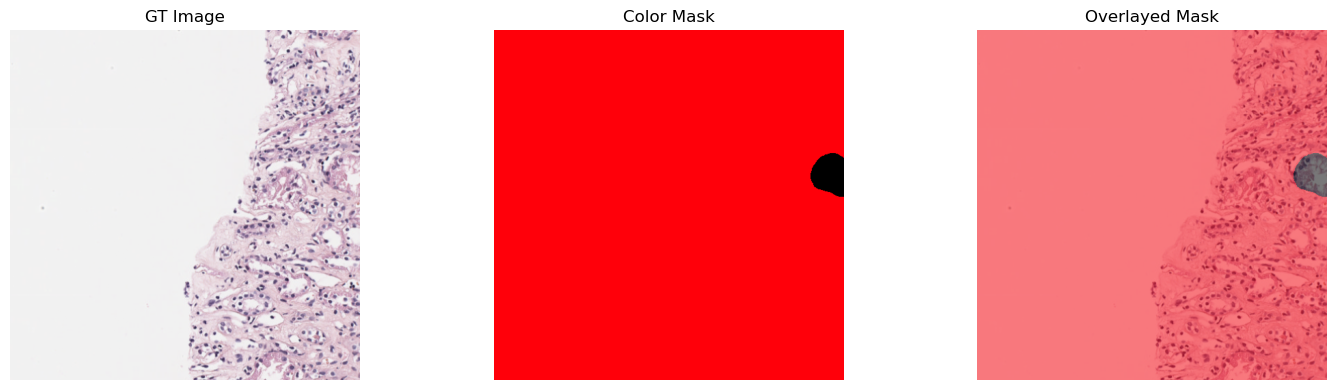

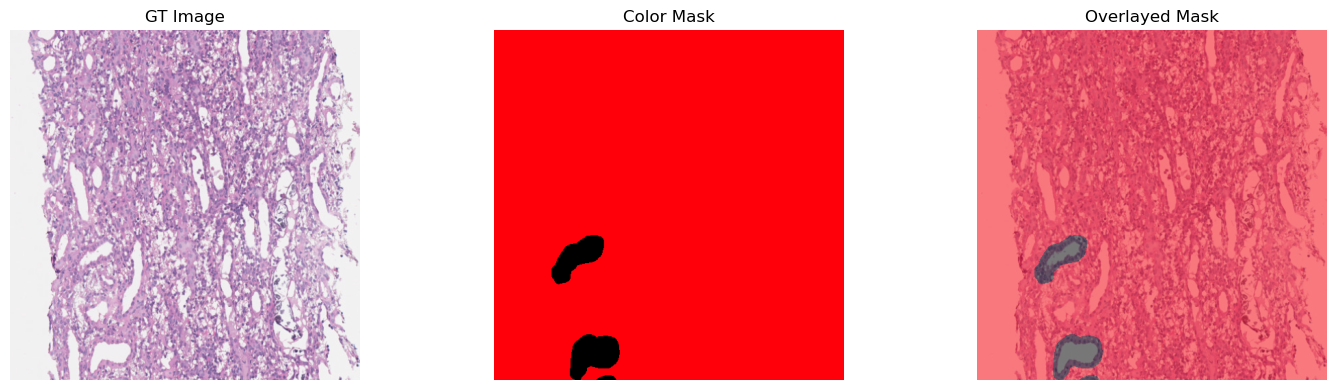

In [18]:
for batch_images, batch_masks in test_loader:
    print(np.unique(batch_masks))
    batch_images = denormalize(batch_images, mean=DatasetConfig.MEAN, std=DatasetConfig.STD).permute(0, 2, 3, 1).numpy()
    batch_masks  = batch_masks.numpy()

    print("batch_images shape:", batch_images.shape)
    print("batch_masks shape: ", batch_masks.shape)
    
    display_image_and_mask(images=batch_images, masks=batch_masks)

    break

**You can check all the trained weights available for SegFormer model on HuggingFace <a href="https://huggingface.co/models?pipeline_tag=image-segmentation&sort=downloads&search=nvidia%2Fsegformer" target="_blank">over here.</a>**

In [19]:
def get_model(*, model_name, num_classes):
    model = SegformerForSemanticSegmentation.from_pretrained(
        model_name,
        num_labels=2,
        ignore_mismatched_sizes=True,
    )
    return model

**Usage**

In [20]:
# Define model
model = get_model(model_name=TrainingConfig.MODEL_NAME, num_classes=DatasetConfig.NUM_CLASSES)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# Create dummy inputs.
data    = torch.randn(1, 3, *DatasetConfig.IMAGE_SIZE[::-1])
target = torch.rand(1, *DatasetConfig.IMAGE_SIZE[::-1]).to(torch.long)

In [22]:
# Generate dummy outputs.
outputs = model(pixel_values=data, labels=target, return_dict=True)

# Upsample model outputs to match input image size.
upsampled_logits = nn.functional.interpolate(outputs["logits"], size=target.shape[-2:], mode="bilinear", align_corners=False)

In [23]:
print("Model Outputs: outputs['logits']:", outputs["logits"].shape)

print("Model Outputs Resized::", upsampled_logits.shape)

print("Loss: outputs['loss']:", outputs["loss"])

Model Outputs: outputs['logits']: torch.Size([1, 2, 128, 128])
Model Outputs Resized:: torch.Size([1, 2, 512, 512])
Loss: outputs['loss']: tensor(0.7093, grad_fn=<NllLoss2DBackward0>)


In [24]:
summary(model, input_size=(1, 3, *DatasetConfig.IMAGE_SIZE[::-1]), depth=2, device="cpu")

Layer (type:depth-idx)                                                      Output Shape              Param #
SegformerForSemanticSegmentation                                            [1, 2, 128, 128]          --
├─SegformerModel: 1-1                                                       [1, 64, 128, 128]         --
│    └─SegformerEncoder: 2-1                                                [1, 64, 128, 128]         60,842,688
├─SegformerDecodeHead: 1-2                                                  [1, 2, 128, 128]          --
│    └─ModuleList: 2-2                                                      --                        789,504
│    └─Conv2d: 2-3                                                          [1, 768, 128, 128]        2,359,296
│    └─BatchNorm2d: 2-4                                                     [1, 768, 128, 128]        1,536
│    └─ReLU: 2-5                                                            [1, 768, 128, 128]        --
│    └─Dropout: 2-6        

In [25]:
def dice_coef_loss(predictions, ground_truths, num_classes=2, dims=(1, 2), smooth=1e-8):
    """Smooth Dice coefficient + Cross-entropy loss function."""

    ground_truth_oh = F.one_hot(ground_truths, num_classes=num_classes)
    prediction_norm = F.softmax(predictions, dim=1).permute(0, 2, 3, 1)

    intersection = (prediction_norm * ground_truth_oh).sum(dim=dims)
    summation = prediction_norm.sum(dim=dims) + ground_truth_oh.sum(dim=dims)

    dice = (2.0 * intersection + smooth) / (summation + smooth)
    dice_mean = dice.mean()

    CE = F.cross_entropy(predictions, ground_truths)

    return (1.0 - dice_mean) + CE

In [26]:
from torchmetrics.classification import MultilabelConfusionMatrix
class MedicalSegmentationModel(pl.LightningModule):
    def __init__(
        self,
        model_name: str,
        num_classes: int = 2,
        init_lr: float = 0.001,
        optimizer_name: str = "Adam",
        weight_decay: float = 1e-4,
        use_scheduler: bool = False,
        scheduler_name: str = "multistep_lr",
        num_epochs: int = 1,
    ):
        super().__init__()

        # Save the arguments as hyperparameters.
        self.save_hyperparameters()

        # Loading model using the function defined above.
        self.model = get_model(model_name=self.hparams.model_name, num_classes=self.hparams.num_classes)

        # Initializing the required metric objects.
        self.mean_train_loss = MeanMetric()
        self.mean_train_f1 = MulticlassF1Score(num_classes=self.hparams.num_classes, average="macro")
        self.mean_valid_loss = MeanMetric()
        self.mean_valid_f1 = MulticlassF1Score(num_classes=self.hparams.num_classes, average="macro")
        self.mean_train_CM = MultilabelConfusionMatrix(num_labels=self.hparams.num_classes)

    def forward(self, data):
        outputs = self.model(pixel_values=data, return_dict=True)
        upsampled_logits = F.interpolate(outputs["logits"], size=data.shape[-2:], mode="bilinear", align_corners=False)
        return upsampled_logits
    
    def training_step(self, batch, *args, **kwargs):
        data, target = batch
        logits = self(data)
        # Calculate Combo loss (Segmentation specific loss (Dice) + cross entropy)
        loss = dice_coef_loss(logits, target, num_classes=self.hparams.num_classes)
        
        self.mean_train_loss(loss, weight=data.shape[0])
        self.mean_train_f1(logits.detach(), target)
        

        self.log("train/batch_loss", self.mean_train_loss, prog_bar=True, logger=False)
        self.log("train/batch_f1", self.mean_train_f1, prog_bar=True, logger=False)
        return loss

    def on_train_epoch_end(self):
        # Computing and logging the training mean loss & mean f1.
        self.log("train/loss", self.mean_train_loss, prog_bar=True)
        self.log("train/f1", self.mean_train_f1, prog_bar=True)
        self.log("epoch", self.current_epoch)

    def validation_step(self, batch, *args, **kwargs):
        data, target = batch
        logits = self(data)
    
        # Calculate Combo loss (Segmentation specific loss (Dice) + cross entropy)
        loss = dice_coef_loss(logits, target, num_classes=self.hparams.num_classes)

        self.mean_valid_loss.update(loss, weight=data.shape[0])
        self.mean_valid_f1.update(logits, target)

    def on_validation_epoch_end(self):
        
        # Computing and logging the validation mean loss & mean f1.
        self.log("valid/loss", self.mean_valid_loss, prog_bar=True)
        self.log("valid/f1", self.mean_valid_f1, prog_bar=True)
        self.log("epoch", self.current_epoch)

    def configure_optimizers(self):
        optimizer = getattr(torch.optim, self.hparams.optimizer_name)(
            filter(lambda p: p.requires_grad, self.model.parameters()),
            lr=self.hparams.init_lr,
            weight_decay=self.hparams.weight_decay,
        )

        LR = self.hparams.init_lr
        WD = self.hparams.weight_decay

        if self.hparams.optimizer_name in ("AdamW", "Adam"):
            optimizer = getattr(torch.optim, self.hparams.optimizer_name)(model.parameters(), lr=LR, 
                                                                          weight_decay=WD, amsgrad=True)
        else:
            optimizer = optim.SGD(model.parameters(), lr=LR, weight_decay=WD)

        if self.hparams.use_scheduler:
            lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[self.trainer.max_epochs // 2,], gamma=0.1)

            # The lr_scheduler_config is a dictionary that contains the scheduler
            # and its associated configuration.
            lr_scheduler_config = {"scheduler": lr_scheduler, "interval": "epoch", "name": "multi_step_lr"}
            return {"optimizer": optimizer, "lr_scheduler": lr_scheduler_config}

        else:
            return optimizer

In [27]:
# Seed everything for reproducibility.
pl.seed_everything(42, workers=True)

model = MedicalSegmentationModel(
    model_name=TrainingConfig.MODEL_NAME,
    num_classes=DatasetConfig.NUM_CLASSES,
    init_lr=TrainingConfig.INIT_LR,
    optimizer_name=TrainingConfig.OPTIMIZER_NAME,
    weight_decay=TrainingConfig.WEIGHT_DECAY,
    use_scheduler=TrainingConfig.USE_SCHEDULER,
    scheduler_name=TrainingConfig.SCHEDULER,
    num_epochs=TrainingConfig.NUM_EPOCHS,
)

data_module = MedicalSegmentationDataModule(
    num_classes=DatasetConfig.NUM_CLASSES,
    img_size=DatasetConfig.IMAGE_SIZE,
    ds_mean=DatasetConfig.MEAN,
    ds_std=DatasetConfig.STD,
    batch_size= TrainingConfig.BATCH_SIZE,
    num_workers=TrainingConfig.NUM_WORKERS,
    pin_memory=torch.cuda.is_available(),
)

Seed set to 42
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Next, we will define a `ModelCheckpoint` and a `LearningRateMonitor` callback for saving the best model during training and the current learning rate of an epoch.

In [28]:
# Creating ModelCheckpoint callback. 
# We'll save the model on basis on validation f1-score.
model_checkpoint = ModelCheckpoint(
    monitor="valid/f1",
    mode="max",
    filename="ckpt_{epoch:03d}-vloss_{valid/loss:.4f}_vf1_{valid/f1:.4f}",
    auto_insert_metric_name=False,
)

# Creating a learning rate monitor callback which will be plotted/added in the default logger.
lr_rate_monitor = LearningRateMonitor(logging_interval="epoch")

In [29]:
# Initialize logger.
wandb_logger = WandbLogger(log_model=True, project="tubuli")

**Train**

In [30]:
# Initializing the Trainer class object.
trainer = pl.Trainer(
    accelerator="auto",  # Auto select the best hardware accelerator available
    devices="auto",  # Auto select available devices for the accelerator (For eg. mutiple GPUs)
    strategy="auto",  # Auto select the distributed training strategy.
    max_epochs=TrainingConfig.NUM_EPOCHS,  # Maximum number of epoch to train for.
    enable_model_summary=False,  # Disable printing of model summary as we are using torchinfo.
    callbacks=[model_checkpoint, lr_rate_monitor],  # Declaring callbacks to use.
    logger=wandb_logger
)

# Start training
trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 0: 100%|██████████| 541/541 [1:44:05<00:00,  0.09it/s, v_num=sxwi, train/batch_loss=0.303, train/batch_f1=0.797, valid/loss=0.601, valid/f1=0.506]

`Trainer.fit` stopped: `max_epochs=1` reached.


Epoch 0: 100%|██████████| 541/541 [1:44:10<00:00,  0.09it/s, v_num=sxwi, train/batch_loss=0.303, train/batch_f1=0.797, valid/loss=0.601, valid/f1=0.506]


wandb: WARNING Artifacts logged anonymously cannot be claimed and expire after 7 days.


## Inference on the Medical Segmentation Dataset

In [31]:
# Get the path of the best saved model.
#CKPT_PATH = model_checkpoint.best_model_path
CKPT_PATH = "C:\\Users\\minik\\Desktop\\Ноутбуки для GitHub\\tubuli\\tfv8xrf5\\checkpoints\\ckpt_000-vloss_0.6009_vf1_0.5060.ckpt"

In [32]:
model = MedicalSegmentationModel.load_from_checkpoint(CKPT_PATH)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b4-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [33]:
# Get the validation dataloader.

data_module.setup()
valid_loader = data_module.val_dataloader()


In [34]:
data_module.setup()
testing_loader = data_module.test_dataloader()


In [35]:
# Initialize trainer class for inference.
trainer = pl.Trainer(
    accelerator="gpu",
    devices=1,        
    enable_checkpointing=False,
    inference_mode=True,
)

# Run evaluation.
results = trainer.validate(model=model, dataloaders=testing_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 248/248 [00:44<00:00,  5.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           epoch           │            0.0            │
│         valid/f1          │    0.5118057727813721     │
│        valid/loss         │    0.5659773945808411     │
└───────────────────────────┴───────────────────────────┘

Log them as experiment summary metrics to WandB.

In [36]:
if os.environ.get("LOCAL_RANK", None) is None:
    wandb.run.summary["best_valid_f1"] = results[0]["valid/f1"]
    wandb.run.summary["best_valid_loss"] = results[0]["valid/loss"]

In [37]:
@torch.inference_mode()
def inference(model, loader, img_size, device="cpu"):
    num_batches_to_process = InferenceConfig.NUM_BATCHES

    for idx, (batch_img, batch_mask) in enumerate(loader):
        predictions = model(batch_img.to(device))

        pred_all = predictions.argmax(dim=1).cpu().numpy()

        batch_img = denormalize(batch_img.cpu(), mean=DatasetConfig.MEAN, std=DatasetConfig.STD)
        batch_img = batch_img.permute(0, 2, 3, 1).numpy()

        if idx == num_batches_to_process:
            break

        for i in range(0, len(batch_img)):
            fig = plt.figure(figsize=(20, 8))

            # Display the original image.
            ax1 = fig.add_subplot(1, 4, 1)
            ax1.imshow(batch_img[i])
            ax1.title.set_text("Actual frame")
            plt.axis("off")

            # Display the ground truth mask.
            true_mask_rgb = num_to_rgb(batch_mask[i], color_map=id2color)
            ax2 = fig.add_subplot(1, 4, 2)
            ax2.set_title("Ground truth labels")
            ax2.imshow(true_mask_rgb)
            plt.axis("off")

            # Display the predicted segmentation mask.
            pred_mask_rgb = num_to_rgb(pred_all[i], color_map=id2color)
            ax3 = fig.add_subplot(1, 4, 3)
            ax3.set_title("Predicted labels")
            ax3.imshow(pred_mask_rgb)
            plt.axis("off")

            # Display the predicted segmentation mask overlayed on the original image.
            overlayed_image = image_overlay(batch_img[i], pred_mask_rgb)
            ax4 = fig.add_subplot(1, 4, 4)
            ax4.set_title("Overlayed image")
            ax4.imshow(overlayed_image)
            plt.axis("off")
            plt.show()
            
            # Upload predictions to WandB.
            images = wandb.Image(fig, caption=f"Prediction Sample {idx}_{i}")
            
            #if os.environ.get("LOCAL_RANK", None) is None:
            #    wandb.log({"Predictions": images})

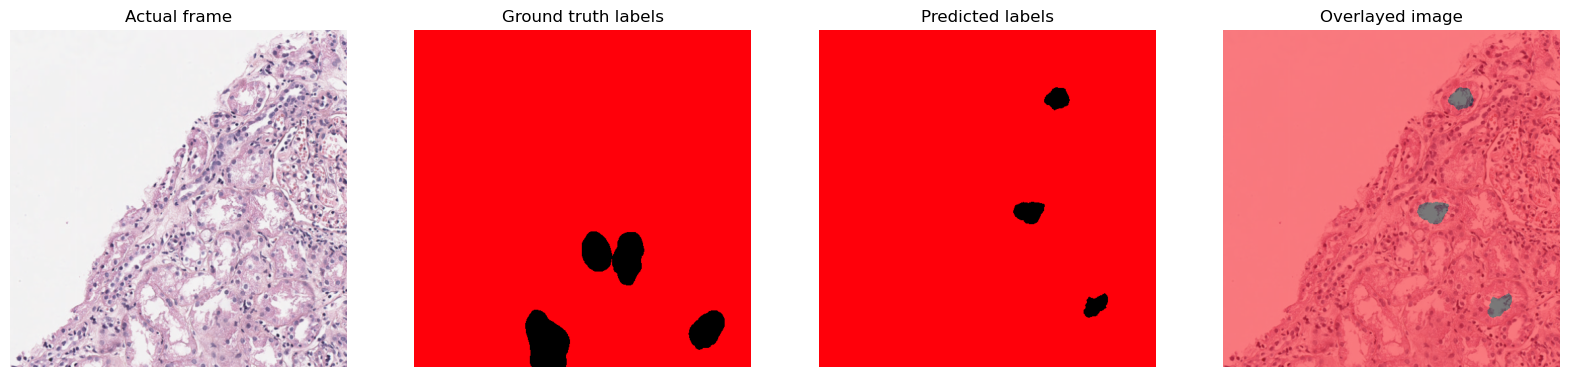

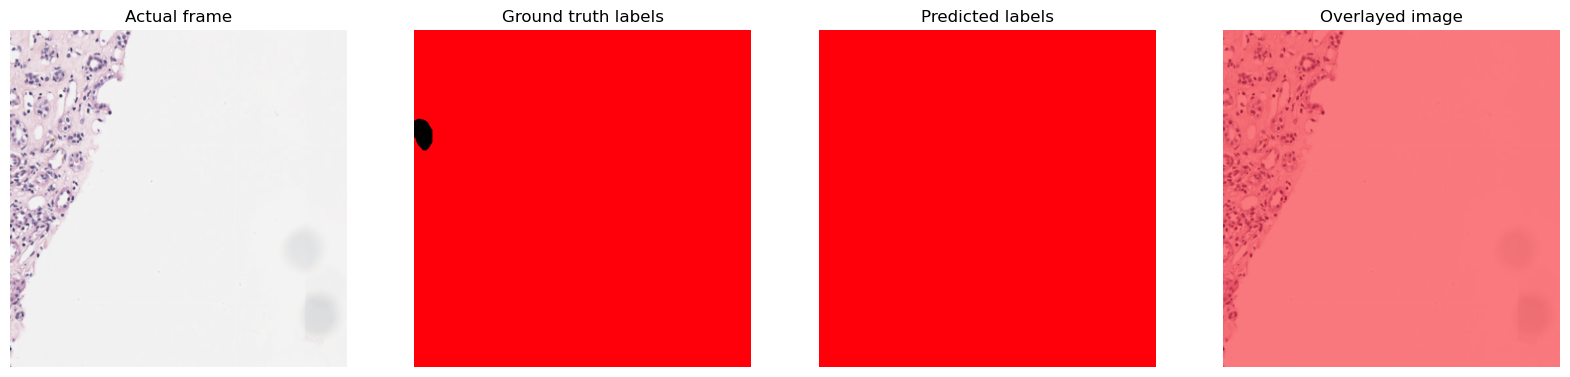

In [47]:
# Use GPU if available.
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model.to(DEVICE)
model.eval()

inference(model, testing_loader, device=DEVICE, img_size=DatasetConfig.IMAGE_SIZE)

In [39]:
if os.environ.get("LOCAL_RANK", None) is None:
    wandb.run.finish()

wandb: ERROR Control-C detected -- Run data was not synced
